<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/blob/main/Chapter08/Detectron2_Chapter08_Transforms.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 08 - Transforms

## Download sample images

In [ ]:
!python --version

In [ ]:
import torch
torch.__version__

In [ ]:
!wget --quiet https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/raw/main/datasets/Chapter08.zip
!unzip --q Chapter08.zip

Archive:  Chapter08.zip
  inflating: Chapter08/1.jpg         
  inflating: Chapter08/2.jpg         
  inflating: Chapter08/3.jpg         
  inflating: Chapter08/4.jpg         


In [ ]:
!python -m  pip install --q \
'git+https://github.com/facebookresearch/detectron2.git'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 19.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from detectron2.utils.visualizer import Visualizer

def imshow(image):
  dpi = plt.rcParams["figure.dpi"]
  im_data = image[:,:, ::-1]
  height, width, depth = im_data.shape
  figsize = width / float(dpi), height / float(dpi)
  fig = plt.figure(figsize=figsize)
  plt.imshow(im_data)
  plt.imshow(im_data)
  plt.axis("off")
  plt.show()

def visualize_image_boxes(img, boxes, colors=['k']):
  v = Visualizer(img, metadata={})
  v = v.overlay_instances(
      boxes=boxes, 
      assigned_colors=colors
      )
  im_data = v.get_image()
  imshow(im_data)
  
def visualize_sample(sample):
  img = sample['image'].to("cpu").numpy()
  img = np.moveaxis(img, 0, -1)
  boxes = sample['instances'].get('gt_boxes')
  visualize_image_boxes(img, boxes)

In [ ]:
import detectron2.data.transforms as T

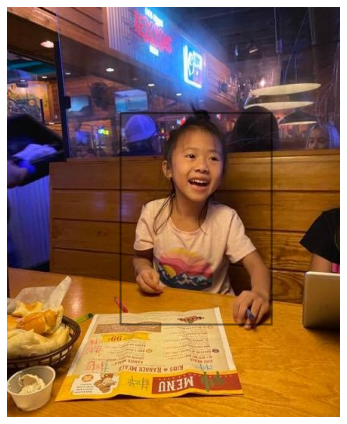

In [ ]:
# data
img = cv2.imread("Chapter08/1.jpg")
boxes = np.array([[150, 140, 350, 420]])
visualize_image_boxes(img, boxes = boxes)

## ExtentTransform

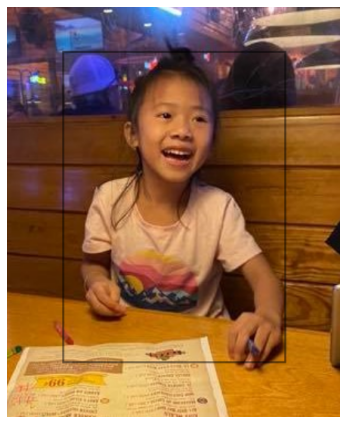

In [ ]:
e_tfm = T.ExtentTransform(
    src_rect = (100, 100, 400, 470), 
    output_size = img.shape[:2]
    )
et_img = e_tfm.apply_image(img)
et_boxes = e_tfm.apply_box(boxes)
visualize_image_boxes(et_img, boxes = et_boxes)

## RotationTransform

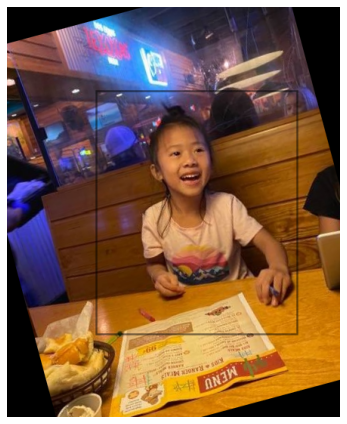

In [ ]:
r_tfm = T.RotationTransform(
    *img.shape[:2], 
    angle = 15,
    expand=False
    )
rt_img = r_tfm.apply_image(img)
rt_boxes = r_tfm.apply_box(boxes)
visualize_image_boxes(rt_img, boxes = rt_boxes)

## GridSampleTransform and PincushionTransform

In [ ]:
class PincushionTransform(T.GridSampleTransform):
  def __init__(self, img_h, img_w):
    self.img_h = img_h
    self.img_w = img_w
    # grid
    X_range = [np.cos(x) for x in np.linspace(np.pi, 0, 441)]
    Y_range = [np.cos(y) for y in np.linspace(np.pi, 0, 543)]
    X_range = np.array(X_range)
    Y_range = np.array(Y_range)
    X, Y = np.meshgrid(X_range, Y_range)
    grid = np.expand_dims(np.stack([X, Y], axis=2), axis=0)
    grid = grid.astype('float32')
    super().__init__(grid=grid, interp="nearest")
    self.X_range = X_range
    self.Y_range = Y_range
  
  def apply_box(self, box: np.ndarray) -> np.ndarray:
    return np.array([self._apply_1_box(b) for b in box])
    
  def _apply_1_box(self, box):
    gs_box = np.array(box)
    img_width = self.img_w
    img_height = self.img_h
    X_range = self.X_range
    Y_range = self.Y_range
    x0x1 = 2*gs_box[[0, 2]]/img_width - 1
    y0y1 = 2*gs_box[[1, 3]]/img_height - 1
    x0x1 = [X_range.searchsorted(x0x1[0]), 
            X_range.searchsorted(x0x1[1])]
    y0y1 = [Y_range.searchsorted(y0y1[0]), 
            Y_range.searchsorted(y0y1[1])]
    gs_box = [min(x0x1), min(y0y1), max(x0x1), max(y0y1)]
    return gs_box


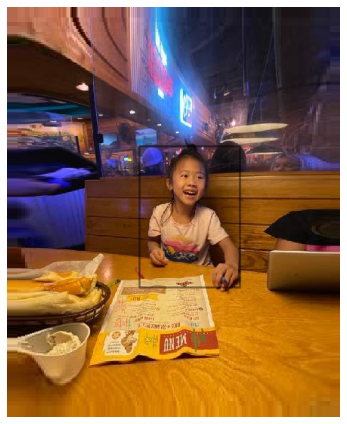

In [ ]:
fc_tfm = PincushionTransform(*img.shape[:2])
fc_img = fc_tfm.apply_image(img)
fc_boxes = fc_tfm.apply_box(boxes)
visualize_image_boxes(fc_img, boxes = fc_boxes)

## BlendTransform

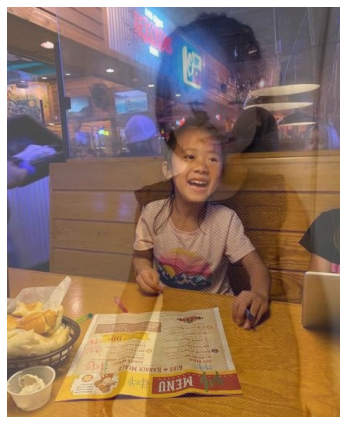

In [ ]:
src_img = img
dst_img = cv2.imread("Chapter08/4.jpg")
src_weight = 0.7
dst_weight = 0.3
# crop
src_w = src_img.shape[1]
src_h = src_img.shape[0]
cr_tfm = T.CropTransform(0, 0, src_w, src_h)
dst_img = cr_tfm.apply_image(dst_img)
# blend
bl_tfm = T.BlendTransform(src_img, src_weight, dst_weight)
bl_img = bl_tfm.apply_image(dst_img)
imshow(bl_img)

## CropTransform, PadTransform, and TransformList

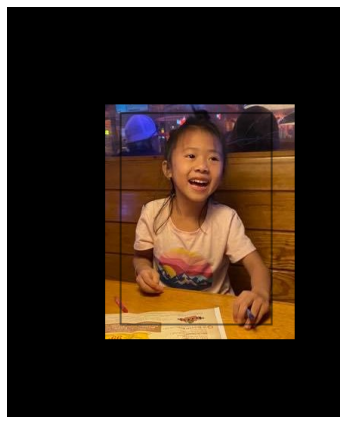

In [ ]:
x0, y0, w, h = (130, 130, 250, 310)
y1, x1 = img.shape[:2] - np.array([y0+h, x0+w])
cr_tfm = T.CropTransform(x0, y0, w, h)
pd_tfm = T.PadTransform(x0, y0, x1, y1)
lst_tfm = T.TransformList([cr_tfm, pd_tfm])
lst_img = lst_tfm.apply_image(img)
lst_boxes = lst_tfm.apply_box(boxes)
visualize_image_boxes(lst_img, boxes = lst_boxes)